<a id = 1></a>
<h1><font color = MidnightBlue>Import Libraries</font></h1>
<hr style="width:100%;height:1.2px;border-width:0;background-color:silver">

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
import string 

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import keras
from keras.preprocessing import text,sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout

import warnings
warnings.filterwarnings('ignore')

import os



In [3]:
for dirname, _, filenames in os.walk('/Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [4]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


<a id = 2></a>
<h1><font color = MidnightBlue>Load and Check Data</font></h1>
<hr style="width:100%;height:1.2px;border-width:0;background-color:silver">

In [5]:
real_data = pd.read_csv('Dataset/True.csv')
fake_data = pd.read_csv('Dataset/Fake.csv')

In [11]:
real_data = real_data[:4000]
fake_data = fake_data[:4000]
real_data.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [12]:
fake_data.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [13]:
#add column 
real_data['target'] = 1
fake_data['target'] = 0 

In [14]:
real_data.tail()

,title,text,subject,date,target
3995,Exclusive: Trump says he thought being preside...,"WASHINGTON (Reuters) - He misses driving, fee...",politicsNews,"April 28, 2017",1
3996,EPA says website undergoing makeover to match ...,WASHINGTON (Reuters) - The website of the U.S....,politicsNews,"April 29, 2017",1
3997,Trump to order a study on abuses of U.S. trade...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"April 29, 2017",1
3998,Highlights: The Trump presidency on April 28 a...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"April 28, 2017",1
3999,"Trump aims to expand U.S. offshore drilling, d...",WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 28, 2017",1


In [15]:
#Merging the 2 datasets
data = pd.concat([real_data, fake_data], ignore_index=True, sort=False)
data.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [16]:
data.isnull().sum()

title      0
text       0
subject    0
date       0
target     0
dtype: int64

<a id = 3></a>
<h1><font color = MidnightBlue>Visualization</font></h1>
<hr style="width:100%;height:1.2px;border-width:0;background-color:silver">

**1.Count of Fake and Real Data**

target
1    4000
0    4000
Name: count, dtype: int64


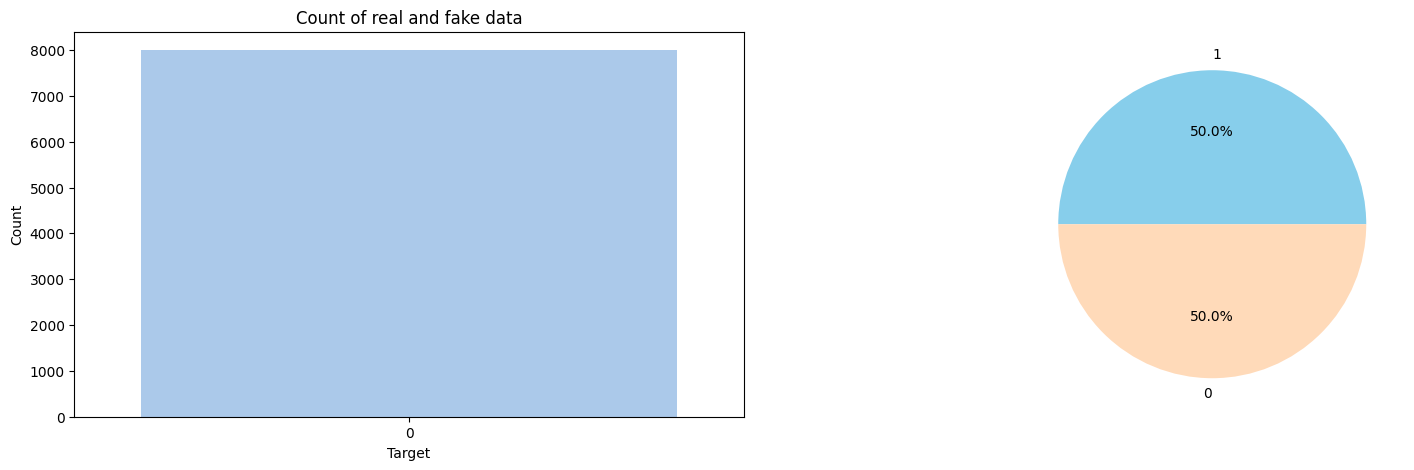

In [17]:
print(data["target"].value_counts())
fig, ax = plt.subplots(1,2, figsize=(19, 5))
g1 = sns.countplot(data.target,ax=ax[0],palette="pastel");
g1.set_title("Count of real and fake data")
g1.set_ylabel("Count")
g1.set_xlabel("Target")
g2 = plt.pie(data["target"].value_counts().values,explode=[0,0],labels=data.target.value_counts().index, autopct='%1.1f%%',colors=['SkyBlue','PeachPuff'])
fig.show()

**2.Distribution of The Subject According to Real and Fake Data**

subject
politicsNews    4000
News            4000
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of The Subject According to Real and Fake Data')

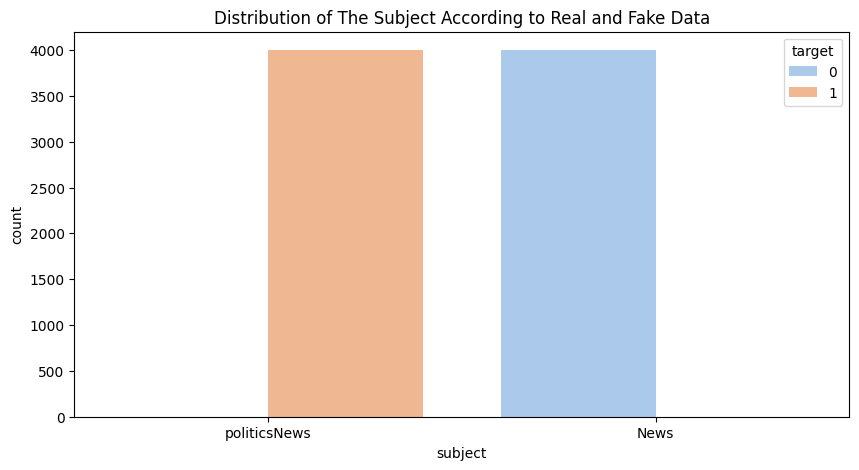

In [18]:
print(data.subject.value_counts())
plt.figure(figsize=(10, 5))

ax = sns.countplot(x="subject",  hue='target', data=data, palette="pastel")
plt.title("Distribution of The Subject According to Real and Fake Data")

<a id = 4></a>
<h1><font color = MidnightBlue>Data Cleaning</font></h1>
<hr style="width:100%;height:1.2px;border-width:0;background-color:silver">

In [19]:
data['text']= data['subject'] + " " + data['title'] + " " + data['text']
del data['title']
del data['subject']
del data['date']
data.head()

,text,target
0,"politicsNews As U.S. budget fight looms, Repub...",1
1,politicsNews U.S. military to accept transgend...,1
2,politicsNews Senior U.S. Republican senator: '...,1
3,politicsNews FBI Russia probe helped by Austra...,1
4,politicsNews Trump wants Postal Service to cha...,1


In [20]:
first_text = data.text[10]
first_text

'politicsNews Jones certified U.S. Senate winner despite Moore challenge (Reuters) - Alabama officials on Thursday certified Democrat Doug Jones the winner of the state’s U.S. Senate race, after a state judge denied a challenge by Republican Roy Moore, whose campaign was derailed by accusations of sexual misconduct with teenage girls. Jones won the vacant seat by about 22,000 votes, or 1.6 percentage points, election officials said. That made him the first Democrat in a quarter of a century to win a Senate seat in Alabama.  The seat was previously held by Republican Jeff Sessions, who was tapped by U.S. President Donald Trump as attorney general. A state canvassing board composed of Alabama Secretary of State John Merrill, Governor Kay Ivey and Attorney General Steve Marshall certified the election results. Seating Jones will narrow the Republican majority in the Senate to 51 of 100 seats. In a statement, Jones called his victory “a new chapter” and pledged to work with both parties. M

<a id = 5></a>
<h2><font color = MidnightBlue>Removal of HTML Contents</font></h2>

**First, let's remove HTML content.**

In [21]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(first_text, "html.parser")
first_text = soup.get_text()
first_text

'politicsNews Jones certified U.S. Senate winner despite Moore challenge (Reuters) - Alabama officials on Thursday certified Democrat Doug Jones the winner of the state’s U.S. Senate race, after a state judge denied a challenge by Republican Roy Moore, whose campaign was derailed by accusations of sexual misconduct with teenage girls. Jones won the vacant seat by about 22,000 votes, or 1.6 percentage points, election officials said. That made him the first Democrat in a quarter of a century to win a Senate seat in Alabama.  The seat was previously held by Republican Jeff Sessions, who was tapped by U.S. President Donald Trump as attorney general. A state canvassing board composed of Alabama Secretary of State John Merrill, Governor Kay Ivey and Attorney General Steve Marshall certified the election results. Seating Jones will narrow the Republican majority in the Senate to 51 of 100 seats. In a statement, Jones called his victory “a new chapter” and pledged to work with both parties. M

<a id = 6></a>
<h2><font color = MidnightBlue>Removal of Punctuation Marks and Special Characters</font></h2>

**Let's now remove everything except uppercase / lowercase letters using Regular Expressions.**

In [22]:
first_text = re.sub('\[[^]]*\]', ' ', first_text)
first_text = re.sub('[^a-zA-Z]',' ',first_text)  # replaces non-alphabets with spaces
first_text = first_text.lower() # Converting from uppercase to lowercase
first_text

'politicsnews jones certified u s  senate winner despite moore challenge  reuters    alabama officials on thursday certified democrat doug jones the winner of the state s u s  senate race  after a state judge denied a challenge by republican roy moore  whose campaign was derailed by accusations of sexual misconduct with teenage girls  jones won the vacant seat by about        votes  or     percentage points  election officials said  that made him the first democrat in a quarter of a century to win a senate seat in alabama   the seat was previously held by republican jeff sessions  who was tapped by u s  president donald trump as attorney general  a state canvassing board composed of alabama secretary of state john merrill  governor kay ivey and attorney general steve marshall certified the election results  seating jones will narrow the republican majority in the senate to    of     seats  in a statement  jones called his victory  a new chapter  and pledged to work with both parties  m

<a id = 7></a>
<h2><font color = MidnightBlue>Removal of Stopwords</font></h2>

**Let's remove stopwords like is,a,the... Which do not offer much insight.**

In [23]:

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords  

# we can use tokenizer instead of split
first_text = nltk.word_tokenize(first_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\majma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\majma\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\majma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
first_text = [ word for word in first_text if not word in set(stopwords.words("english"))]

<a id = 8></a>
<h2><font color = MidnightBlue>Lemmatization</font></h2>

**Lemmatization to bring back multiple forms of same word to their common root like 'coming', 'comes' into 'come'.**

In [25]:
lemma = nltk.WordNetLemmatizer()
first_text = [ lemma.lemmatize(word) for word in first_text] 

first_text = " ".join(first_text)
first_text

'politicsnews jones certified u senate winner despite moore challenge reuters alabama official thursday certified democrat doug jones winner state u senate race state judge denied challenge republican roy moore whose campaign derailed accusation sexual misconduct teenage girl jones vacant seat vote percentage point election official said made first democrat quarter century win senate seat alabama seat previously held republican jeff session tapped u president donald trump attorney general state canvassing board composed alabama secretary state john merrill governor kay ivey attorney general steve marshall certified election result seating jones narrow republican majority senate seat statement jones called victory new chapter pledged work party moore declined concede defeat even trump urged stood claim fraudulent election statement released certification said regret medium outlet reported alabama judge denied moore request block certification result dec election decision shortly canvass

<a id = 9></a>
<h2><font color = MidnightBlue>Perform it for all the examples</font></h2>
<b>We performed the steps for a single example. Now let's perform it for all the examples in the data.</b>

In [26]:
#Removal of HTML Contents
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removal of Punctuation Marks
def remove_punctuations(text):
    return re.sub('\[[^]]*\]', '', text)

# Removal of Special Characters
def remove_characters(text):
    return re.sub("[^a-zA-Z]"," ",text)

#Removal of stopwords 
def remove_stopwords_and_lemmatization(text):
    final_text = []
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    for word in text:
        if word not in set(stopwords.words('english')):
            lemma = nltk.WordNetLemmatizer()
            word = lemma.lemmatize(word) 
            final_text.append(word)
    return " ".join(final_text)

#Total function
def cleaning(text):
    text = remove_html(text)
    text = remove_punctuations(text)
    text = remove_characters(text)
    text = remove_stopwords_and_lemmatization(text)
    return text

#Apply function on text column
data['text']=data['text'].apply(cleaning)

In [27]:
data.head()

,text,target
0,politicsnews u budget fight loom republican fl...,1
1,politicsnews u military accept transgender rec...,1
2,politicsnews senior u republican senator let m...,1
3,politicsnews fbi russia probe helped australia...,1
4,politicsnews trump want postal service charge ...,1


<h2><b>Let's make some visualization with new data.</b></h2>

<h3><b>1.WordCloud for Real News </b></h3>

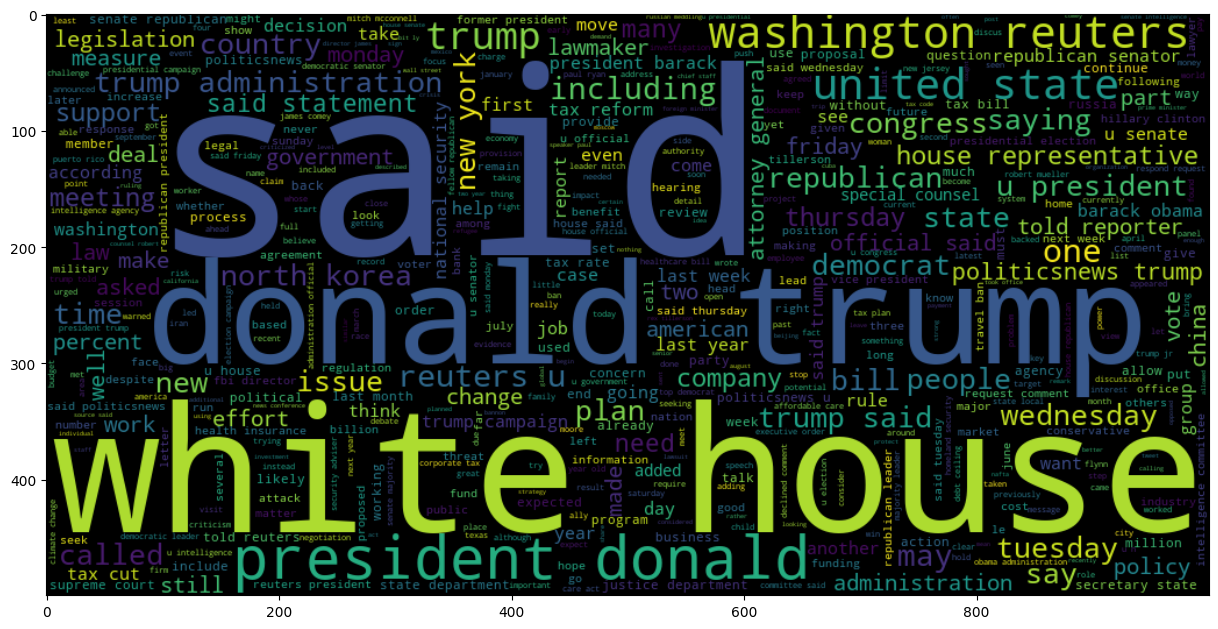

In [28]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(data[data.target == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

<h3><b>2.WordCloud for Fake News </b></h3>

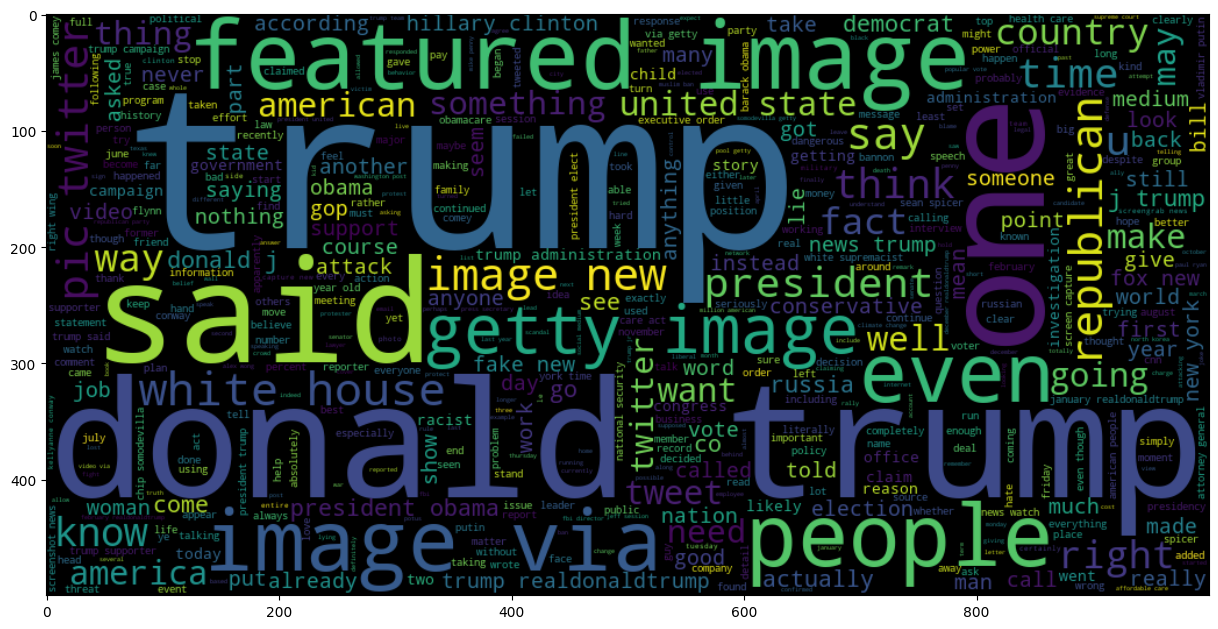

In [29]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(data[data.target == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

<h3><b>Number of words in each text</b></h3>

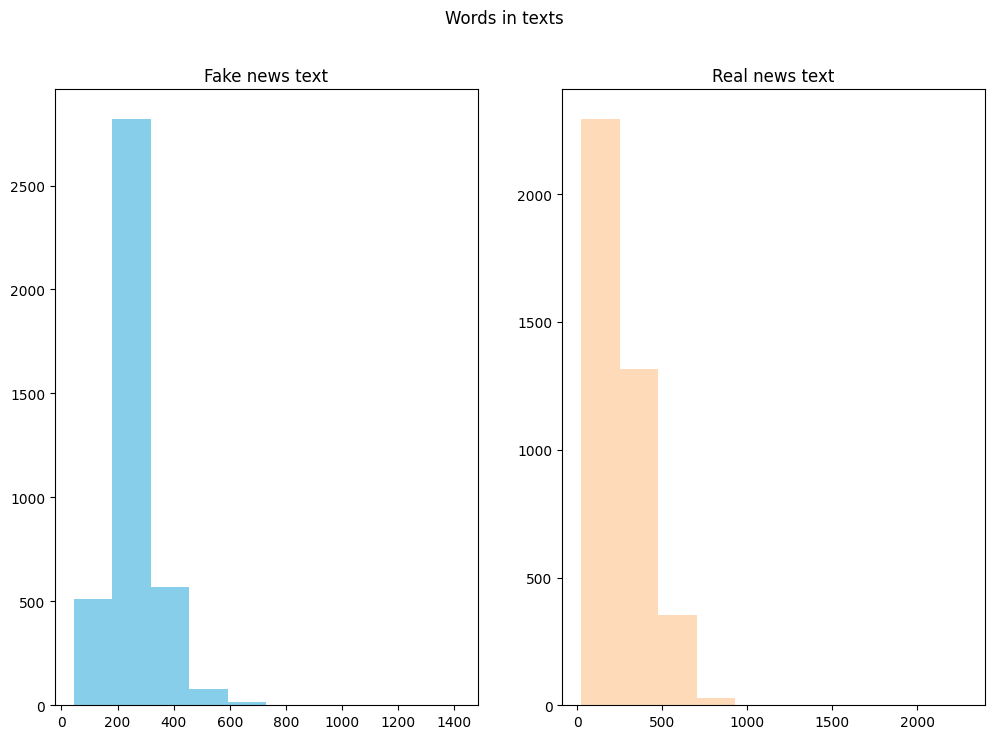

In [30]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=data[data['target']==0]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='SkyBlue')
ax1.set_title('Fake news text')
text_len=data[data['target']==1]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='PeachPuff')
ax2.set_title('Real news text')
fig.suptitle('Words in texts')
plt.show()

**The number of words seems to be a bit different. 500 words  are most common in real news category while around 250 words are most common in fake news category.**

<a id = 10></a>
<h2><font color = white>N-Gram Analysis</font></h2>
<hr style="width:100%;height:1.2px;border-width:0;background-color:silver">
<center><img style = "height:450px;" src="https://devopedia.org/images/article/219/7356.1569499094.png"></center>
<hr style="width:100%;height:1.2px;border-width:0;background-color:silver">

In [31]:
texts = ' '.join(data['text'])

In [32]:
string = texts.split(" ")

In [33]:
def draw_n_gram(string,i):
    n_gram = (pd.Series(nltk.ngrams(string, i)).value_counts())[:15]
    n_gram_df=pd.DataFrame(n_gram)
    n_gram_df = n_gram_df.reset_index()
    n_gram_df = n_gram_df.rename(columns={"index": "word", 0: "count"})
    print(n_gram_df.head())
    plt.figure(figsize = (16,9))
    return sns.barplot(x='count',y='word', data=n_gram_df)

<a id = 11></a>
<h2><font color = MidnightBlue>Unigram Analysis</font></h2>

           word  count
0      (trump,)  49995
1       (said,)  23627
2          (u,)  15969
3  (president,)  13982
4      (would,)  12009


<Axes: xlabel='count', ylabel='word'>

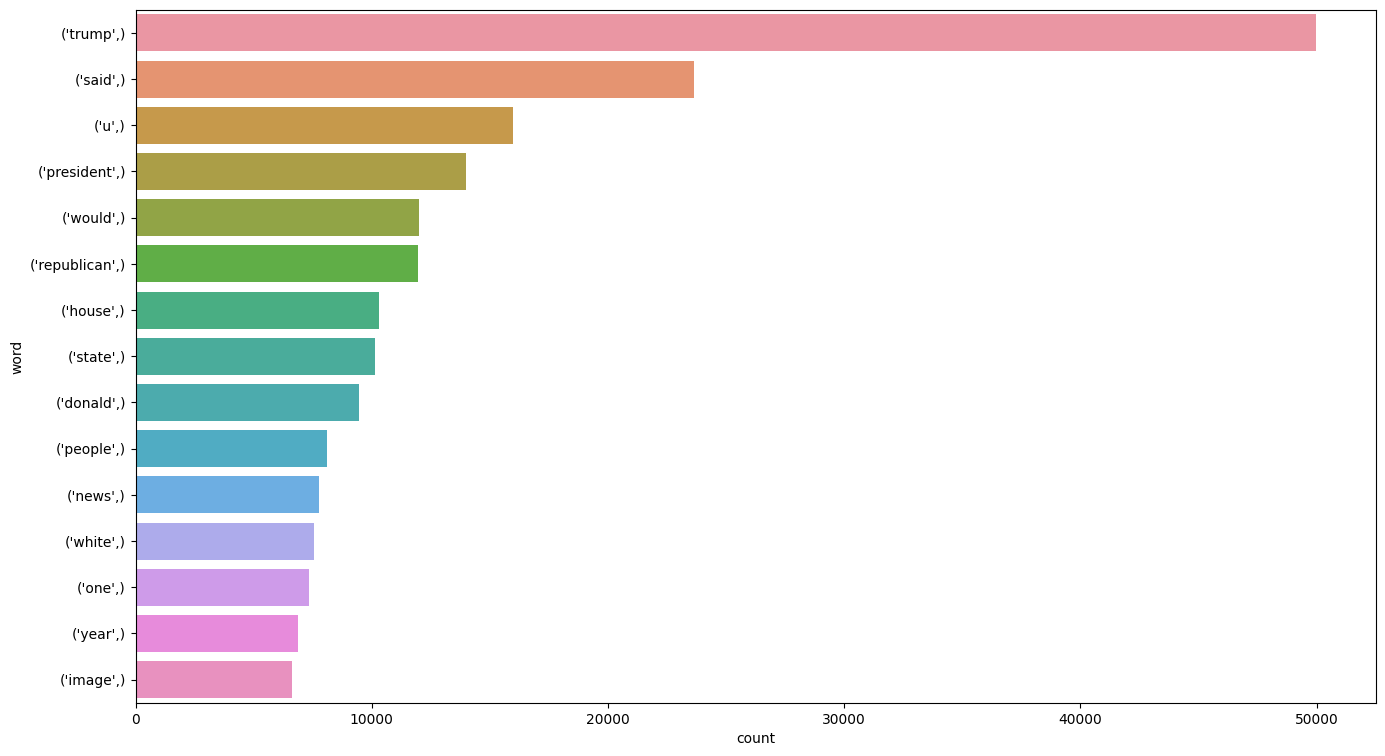

In [34]:
draw_n_gram(string,1)

<a id = 12></a>
<h2><font color = MidnightBlue>Bigram Analysis</font></h2>

                  word  count
0      (donald, trump)   7805
1       (white, house)   5953
2      (united, state)   3660
3    (featured, image)   3499
4  (president, donald)   2992


<Axes: xlabel='count', ylabel='word'>

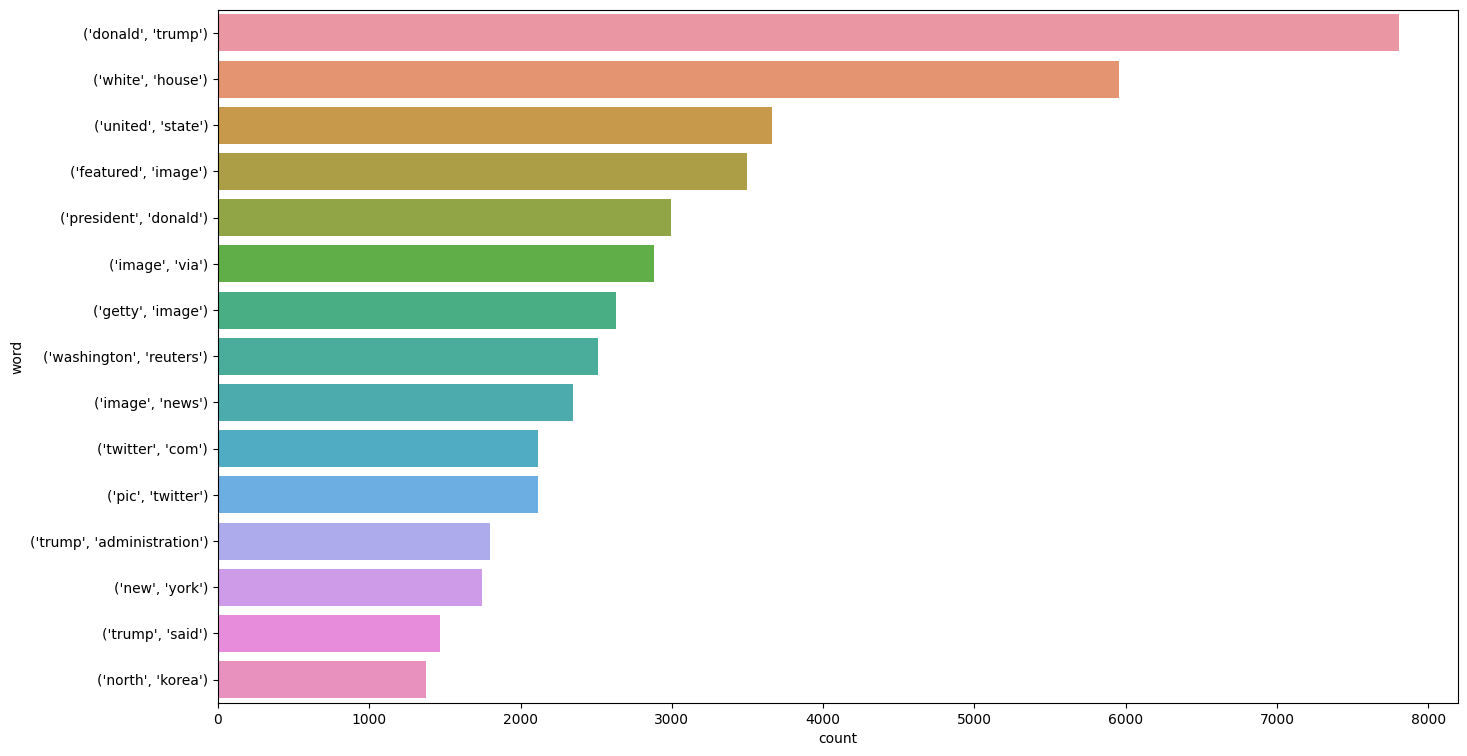

In [35]:
draw_n_gram(string,2)

<a id = 13></a>
<h2><font color = MidnightBlue>Trigram Analysis</font></h2>

                         word  count
0  (president, donald, trump)   6830
1         (pic, twitter, com)   6185
2      (featured, image, via)   6029
3  (president, barack, obama)   3911
4        (getty, image, news)   3575


<Axes: xlabel='count', ylabel='word'>

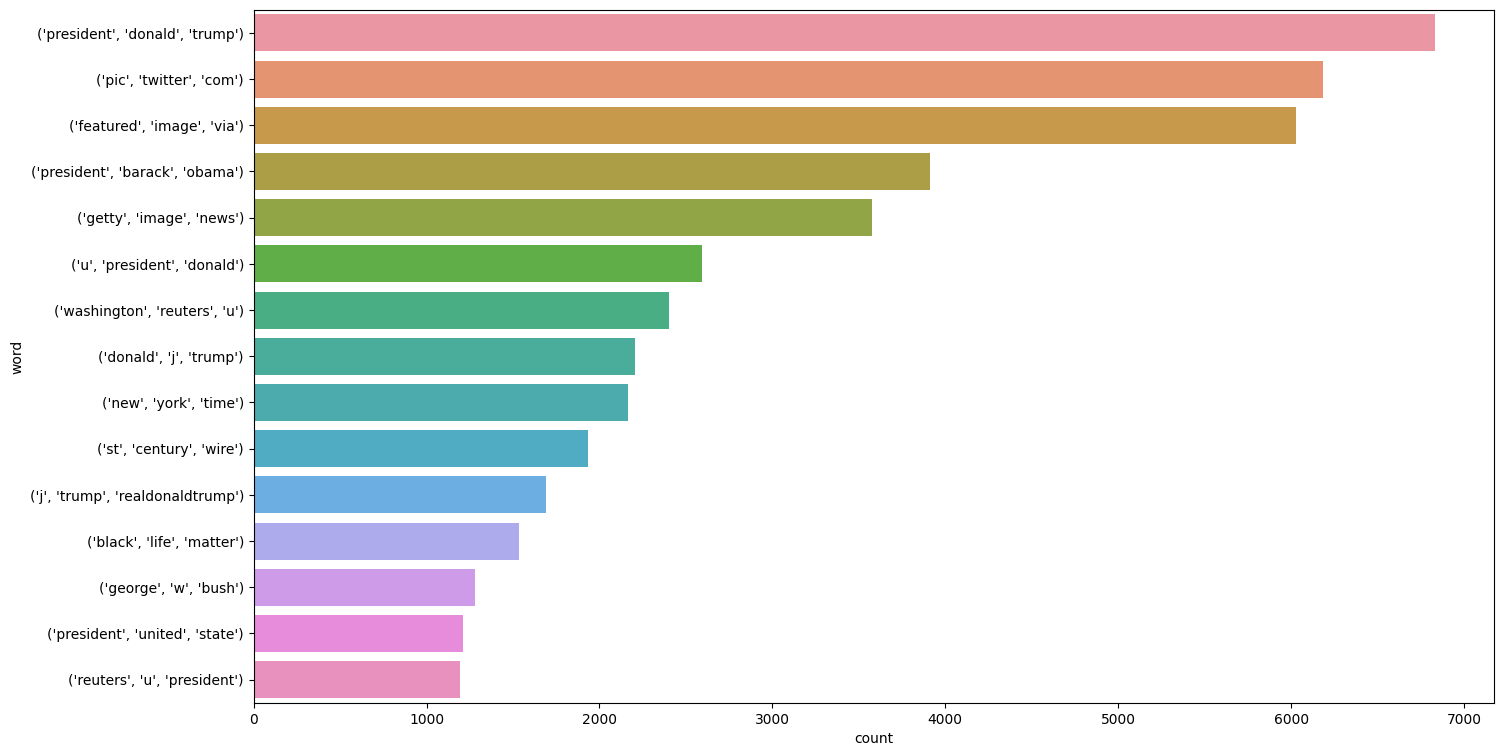

In [36]:
draw_n_gram(string,3)

<a id = 14></a>
<h2><font color = MidnightBlue>Modeling</font></h2>
<hr style="width:100%;height:1.2px;border-width:0;background-color:silver">

<a id = 15></a>
<h2><font color = MidnightBlue>Train Test Split</font></h2>

In [36]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], random_state=0)

<a id = 16></a>
<h2><font color = MidnightBlue>Tokenizing</font></h2>

* **Tokenizing Text -> Repsesenting each word by a number**

* **Mapping of orginal word to number is preserved in word_index property of tokenizer**

<h3><b>Lets keep all news to 300, add padding to news with less than 300 words and truncating long ones </b></h3>

In [38]:
max_features = 10000
maxlen = 300

In [42]:
%pip install --upgrade keras

     ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
     --- ------------------------------------ 0.1/1.7 MB 2.8 MB/s eta 0:00:01
     ------------ --------------------------- 0.5/1.7 MB 5.6 MB/s eta 0:00:01
     ---------------------- ----------------- 1.0/1.7 MB 6.9 MB/s eta 0:00:01
     ------------------------------ --------- 1.3/1.7 MB 7.1 MB/s eta 0:00:01
     ---------------------------------------  1.7/1.7 MB 7.3 MB/s eta 0:00:01
     ---------------------------------------- 1.7/1.7 MB 6.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
    Uninstalling keras-2.10.0:
      Successfully uninstalled keras-2.10.0
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.10.1 requires keras<2.11,>=2.10.0, but you have keras 2.12.0 which is incompatible.


In [42]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(tokenized_train, maxlen=maxlen)

In [44]:
tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(tokenized_test, maxlen=maxlen)

<a id = 17></a>
<h2><font color = MidnightBlue>Training LSTM Model</font></h2>

In [45]:
batch_size = 256
epochs = 10
embed_size = 100

In [46]:
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 300, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [48]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=batch_size, shuffle=True, verbose = 1)

Epoch 1/10
17/17 [==============================] - 62s 3s/step - loss: 0.4750 - accuracy: 0.7660 - val_loss: 0.0666 - val_accuracy: 0.9806
Epoch 2/10
17/17 [==============================] - 54s 3s/step - loss: 0.0503 - accuracy: 0.9881 - val_loss: 0.0340 - val_accuracy: 0.9933
Epoch 3/10
17/17 [==============================] - 55s 3s/step - loss: 0.0427 - accuracy: 0.9905 - val_loss: 0.0330 - val_accuracy: 0.9933
Epoch 4/10
17/17 [==============================] - 54s 3s/step - loss: 0.0429 - accuracy: 0.9902 - val_loss: 0.0317 - val_accuracy: 0.9944
Epoch 5/10
17/17 [==============================] - 54s 3s/step - loss: 0.0366 - accuracy: 0.9931 - val_loss: 0.0315 - val_accuracy: 0.9939
Epoch 6/10
17/17 [==============================] - 55s 3s/step - loss: 0.0351 - accuracy: 0.9938 - val_loss: 0.0306 - val_accuracy: 0.9944
Epoch 7/10
17/17 [==============================] - 57s 3s/step - loss: 0.0350 - accuracy: 0.9929 - val_loss: 0.0311 - val_accuracy: 0.9939
Epoch 8/10
17/17 [==

In [53]:
model.save("fake_news.h5")

In [55]:
import pickle
with open("tokenizer.pkl", "wb") as file:
    pickle.dump(tokenizer, file)

<a id = 18></a>
<h2><font color = MidnightBlue>Analysis After Training </font></h2>

In [49]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

188/188 [==============================] - 57s 302ms/step - loss: 0.0296 - accuracy: 0.9943
Accuracy of the model on Training Data is -  99.43333268165588 %
63/63 [==============================] - 19s 299ms/step - loss: 0.0423 - accuracy: 0.9910
Accuracy of the model on Testing Data is -  99.09999966621399 %


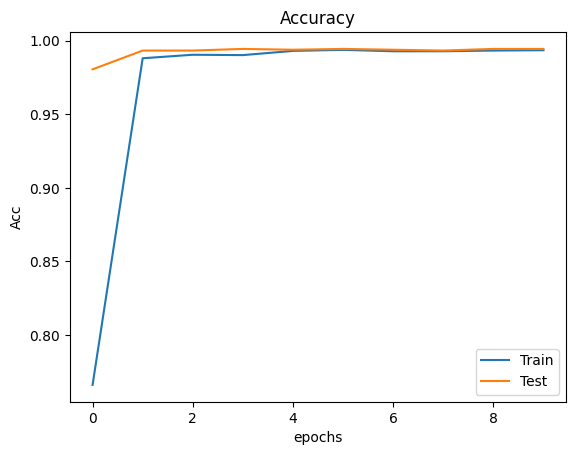

In [50]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

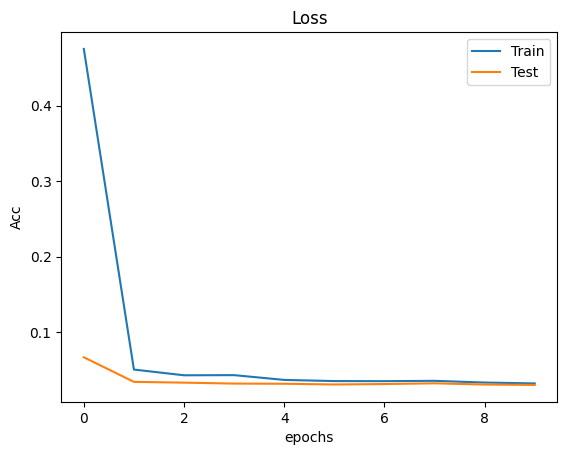

In [51]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [56]:
pred = model.predict(X_test)
print(classification_report(y_test, pred, target_names = ['Fake','Real']))

63/63 [==============================] - 21s 298ms/step


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [58]:
np.round(pred)

array([[1.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]], dtype=float32)